In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

from utils_data import import_process_bike_sharing_data
from utils import printable
import time

# Set all the seeds for reproducibility
import numpy as np
import random
np.random.seed(42)
random.seed(42)




Note: slighly different than mp6 results - we have a different random seed

# Read data

In [3]:
from utils import discretize

df, target_col = import_process_bike_sharing_data()

continuous_attributes = ["temp", "atemp", "hum", "windspeed"]
df_discretized = discretize(df, attributes=continuous_attributes, bins=3, round_v=0)

In [4]:
attributes = list(df.columns)
attributes.remove(target_col)

In [5]:
df

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,winter,2011,1,0,0,Sat,0,good,3.28,25.7886,81.0,0.0000,16
1,winter,2011,1,1,0,Sat,0,good,2.34,25.2718,80.0,0.0000,40
2,winter,2011,1,2,0,Sat,0,good,2.34,25.2718,80.0,0.0000,32
3,winter,2011,1,3,0,Sat,0,good,3.28,25.7886,75.0,0.0000,13
4,winter,2011,1,4,0,Sat,0,good,3.28,25.7886,75.0,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,winter,2021,12,19,0,Mon,1,misty,4.22,24.7584,60.0,11.0014,119
17375,winter,2021,12,20,0,Mon,1,misty,4.22,24.7584,60.0,11.0014,89
17376,winter,2021,12,21,0,Mon,1,good,4.22,24.7584,60.0,11.0014,90
17377,winter,2021,12,22,0,Mon,1,good,4.22,25.2718,56.0,8.9981,61


# Regression model

## Split the data into training and test sets

In [6]:
# Divide the dataset into training and testing sets
index_end_train = int(len(df)*0.7)
X_train, X_test= df[attributes].loc[0:index_end_train], df[attributes].loc[index_end_train+1:]
df_discretized_train, df_discretized_test = df_discretized.loc[0:index_end_train], df_discretized.loc[index_end_train+1:]
y_train, y_test = df[target_col].loc[0:index_end_train], df[target_col].loc[index_end_train+1:]

In [7]:
# Encoding all the categorical features
cat_attr_list = ['season', 'holiday',  'weathersit', 'workingday'] 
# though we have transformed all categoricals into their one-hot encodings, note that ordinal
# attributes such as hour, weekday, and so on do not require such encoding.
numeric_feature_cols = ['temp', 'atemp', 'hum', 'windspeed', 'hr', 'weekday',  'mnth', 'yr']


## Encode variables

In [8]:
from sklearn import preprocessing


oh_enc = preprocessing.OneHotEncoder(sparse_output=False)
other_cols = list(set(X_train.columns) - set(cat_attr_list))

encoded_data = oh_enc.fit_transform(X_train[cat_attr_list].astype(str))
df_train_enc = pd.DataFrame(encoded_data, columns=oh_enc.get_feature_names_out(cat_attr_list))

encoded_data_test = oh_enc.transform(X_test[cat_attr_list].astype(str))
df_test_enc = pd.DataFrame(encoded_data_test, columns=oh_enc.get_feature_names_out(cat_attr_list))

df_train_enc[other_cols] = X_train[other_cols].values
df_test_enc[other_cols] = X_test[other_cols].values

weekday_mapping = {v: i for i, v in enumerate(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])}
df_train_enc["weekday"] = df_train_enc["weekday"].replace(weekday_mapping)
df_test_enc["weekday"] = df_test_enc["weekday"].replace(weekday_mapping)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train_enc[other_cols] = scaler.fit_transform(df_train_enc[other_cols])
df_test_enc[other_cols] = scaler.transform(df_test_enc[other_cols])


/tmp/ipykernel_1994196/1391525516.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train_enc["weekday"] = df_train_enc["weekday"].replace(weekday_mapping)
/tmp/ipykernel_1994196/1391525516.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test_enc["weekday"] = df_test_enc["weekday"].replace(weekday_mapping)


## Regression model - fit and eval

In [9]:
from sklearn import linear_model
lr_model = linear_model.LinearRegression()

#training model in training set
lr_model.fit(df_train_enc, y_train)

# making predection using the test set
y_pred = lr_model.predict(df_test_enc)

In [10]:
#root mean squared error
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


print('RMSE: %.2f' % sqrt(mean_squared_error(y_test, y_pred)))
print('MSE: %.2f' % (mean_squared_error(y_test, y_pred)))
print('MAE: %.2f' % (mean_absolute_error(y_test, y_pred)))
print(r2_score(y_test, y_pred))

RMSE: 183.38
MSE: 33628.10
MAE: 142.39
0.30759894995999537


# True target - DivExplorer

In [11]:
type_outcome = 'quantitative'

In [12]:
target_col = 'cnt'

In [13]:
import resource

def limit_memory(max_mem_mb):
    """Limit memory usage of the current notebook process."""
    soft, hard = max_mem_mb * 1024 * 1024, max_mem_mb * 1024 * 1024
    resource.setrlimit(resource.RLIMIT_AS, (soft, hard))

# Example: Limit the notebook to 2 GB of memory
limit_memory(30*1024)

In [14]:
min_support_count = 100

min_support = min_support_count / len(df_discretized_test)

#min_support = 0.025
import numpy as np
print(min_support, np.round(min_support, 2))  
min_support = np.round(min_support, 2)
print(min_support)
min_support_count = min_support * len(df_discretized_test)
print(min_support_count)

0.01918281220026856 0.02
0.02
104.26


In [15]:
from divexplorer import DivergenceExplorer

fp_diver = DivergenceExplorer(df_discretized_test)

try:
    start_time = time.time()
    if type_outcome == 'boolean':
        subgroups = fp_diver.get_pattern_divergence(min_support=min_support, boolean_outcomes=[target_col], FPM_algorithm='fpgrowth')
    else:
        subgroups = fp_diver.get_pattern_divergence(min_support=min_support, quantitative_outcomes=[target_col], FPM_algorithm='fpgrowth')
    print("--- %s seconds ---" % (time.time() - start_time))
except MemoryError:
    print("Memory limit exceeded!")

--- 0.7405269145965576 seconds ---


In [16]:
from divexplorer import DivergencePatternProcessor


fp_details = DivergencePatternProcessor(subgroups, target_col)

import time
try:
    start_time = time.time()
    patterns = fp_details.get_patterns(th_redundancy=0)
    print("--- %s seconds ---" % (time.time() - start_time))
except MemoryError:
    print("Memory limit exceeded!")

--- 0.08568120002746582 seconds ---


In [17]:
abbreviations = {}

In [18]:
cols = ['itemset', 'support', target_col, f"{target_col}_div", f"{target_col}_t"]

In [19]:
subgroups_print = patterns[cols].sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[False, False]).head(3).copy()
subgroups_print = printable(subgroups_print, target_col, abbreviations=abbreviations, round_v=1)

display(subgroups_print)

print(subgroups_print.to_latex(index=False))

,itemset,support,cnt,cnt_div,cnt_t
10375,"hr=17, workingday=1",0.028,723.3,464.9,28.8
12750,"atemp=>35, holiday=0, hr=17",0.025,722.6,464.2,28.7
13484,"holiday=0, hr=17, temp=>21",0.024,719.6,461.2,27.8


\begin{tabular}{lrrrr}
\toprule
itemset & support & cnt & cnt_div & cnt_t \\
\midrule
hr=17, workingday=1 & 0.028000 & 723.300000 & 464.900000 & 28.800000 \\
atemp=>35, holiday=0, hr=17 & 0.025000 & 722.600000 & 464.200000 & 28.700000 \\
holiday=0, hr=17, temp=>21 & 0.024000 & 719.600000 & 461.200000 & 27.800000 \\
\bottomrule
\end{tabular}



In [20]:
subgroups_print = patterns[cols].sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[True, False]).head(3).copy()
subgroups_print = printable(subgroups_print, target_col, abbreviations=abbreviations, round_v=1)

display(subgroups_print)

print(subgroups_print.to_latex(index=False))

,itemset,support,cnt,cnt_div,cnt_t
10859,"hr=3, workingday=1",0.028,6.2,-252.1,82.1
10730,"hr=4, workingday=1",0.028,7.7,-250.7,81.9
17084,"hr=4, windspeed=<=8",0.020,8.5,-249.9,81.3


\begin{tabular}{lrrrr}
\toprule
itemset & support & cnt & cnt_div & cnt_t \\
\midrule
hr=3, workingday=1 & 0.028000 & 6.200000 & -252.100000 & 82.100000 \\
hr=4, workingday=1 & 0.028000 & 7.700000 & -250.700000 & 81.900000 \\
hr=4, windspeed=<=8 & 0.020000 & 8.500000 & -249.900000 & 81.300000 \\
\bottomrule
\end{tabular}



In [22]:
patterns.loc[patterns['itemset']==frozenset()].iloc[0][target_col].round(1)

258.4

# Predicted DivExplorer

In [23]:
from divexplorer import DivergenceExplorer

target_col = 'cnt_pred'
df_discretized_test_pred = df_discretized_test.copy()
df_discretized_test_pred[target_col] = y_pred
df_discretized_test_pred.drop(columns=['cnt'], inplace=True)

fp_diver = DivergenceExplorer(df_discretized_test_pred)

try:
    start_time = time.time()
    if type_outcome == 'boolean':
        subgroups = fp_diver.get_pattern_divergence(min_support=min_support, boolean_outcomes=[target_col], FPM_algorithm='fpgrowth')
    else:
        subgroups = fp_diver.get_pattern_divergence(min_support=min_support, quantitative_outcomes=[target_col], FPM_algorithm='fpgrowth')
    print("--- %s seconds ---" % (time.time() - start_time))
except MemoryError:
    print("Memory limit exceeded!")

--- 0.7002177238464355 seconds ---


In [24]:
from divexplorer import DivergencePatternProcessor


fp_details = DivergencePatternProcessor(subgroups, target_col)

import time
try:
    start_time = time.time()
    patterns = fp_details.get_patterns(th_redundancy=0)
    print("--- %s seconds ---" % (time.time() - start_time))
except MemoryError:
    print("Memory limit exceeded!")

--- 0.08533906936645508 seconds ---


In [25]:
cols = ['itemset', 'support', target_col, f"{target_col}_div", f"{target_col}_t"]

In [26]:
subgroups_print = patterns[cols].sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[False, False]).head(3).copy()
subgroups_print = printable(subgroups_print, target_col, abbreviations=abbreviations, round_v=1)

display(subgroups_print)

print(subgroups_print.to_latex(index=False))

,itemset,support,cnt_pred,cnt_pred_div,cnt_pred_t
15098,"hum=<=53, temp=>21, weathersit=good, weekday=Sat",0.022,368.7,113.8,28.3
15592,"hum=<=53, season=spring, temp=>21, weathersit=good, workingday=1",0.022,367.9,113.0,30.1
17058,"atemp=>35, hr=15, hum=<=53",0.020,367.7,112.9,39.9


\begin{tabular}{lrrrr}
\toprule
itemset & support & cnt_pred & cnt_pred_div & cnt_pred_t \\
\midrule
hum=<=53, temp=>21, weathersit=good, weekday=Sat & 0.022000 & 368.700000 & 113.800000 & 28.300000 \\
hum=<=53, season=spring, temp=>21, weathersit=good, workingday=1 & 0.022000 & 367.900000 & 113.000000 & 30.100000 \\
atemp=>35, hr=15, hum=<=53 & 0.020000 & 367.700000 & 112.900000 & 39.900000 \\
\bottomrule
\end{tabular}



In [27]:
subgroups_print = patterns[cols].sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[True, False]).head(3).copy()
subgroups_print = printable(subgroups_print, target_col, abbreviations=abbreviations, round_v=1)

display(subgroups_print)

print(subgroups_print.to_latex(index=False))

,itemset,support,cnt_pred,cnt_pred_div,cnt_pred_t
7401,"hum=>73, mnth=12, temp=<=9",0.036,134.5,-120.3,26.7
7400,"atemp=<=29, hum=>73, mnth=12",0.036,134.5,-120.3,26.7
11093,"atemp=<=29, hum=>73, workingday=0",0.027,135.8,-119.0,25.7


\begin{tabular}{lrrrr}
\toprule
itemset & support & cnt_pred & cnt_pred_div & cnt_pred_t \\
\midrule
hum=>73, mnth=12, temp=<=9 & 0.036000 & 134.500000 & -120.300000 & 26.700000 \\
atemp=<=29, hum=>73, mnth=12 & 0.036000 & 134.500000 & -120.300000 & 26.700000 \\
atemp=<=29, hum=>73, workingday=0 & 0.027000 & 135.800000 & -119.000000 & 25.700000 \\
\bottomrule
\end{tabular}



In [28]:
patterns.loc[patterns['itemset']==frozenset()].iloc[0][target_col].round(1)

254.8

# Error - DivExplorer

In [29]:
from divexplorer import DivergenceExplorer

target_col = 'mae'
df_discretized_test_mae = df_discretized_test.copy()
df_discretized_test_mae[target_col] = abs(y_test - y_pred) 
df_discretized_test_mae.drop(columns=['cnt'], inplace=True)

fp_diver = DivergenceExplorer(df_discretized_test_mae)

try:
    start_time = time.time()
    if type_outcome == 'boolean':
        subgroups = fp_diver.get_pattern_divergence(min_support=min_support, boolean_outcomes=[target_col], FPM_algorithm='fpgrowth')
    else:
        subgroups = fp_diver.get_pattern_divergence(min_support=min_support, quantitative_outcomes=[target_col], FPM_algorithm='fpgrowth')
    print("--- %s seconds ---" % (time.time() - start_time))
except MemoryError:
    print("Memory limit exceeded!")

--- 0.5690791606903076 seconds ---


In [30]:
from divexplorer import DivergencePatternProcessor


fp_details = DivergencePatternProcessor(subgroups, target_col)

import time
try:
    start_time = time.time()
    patterns = fp_details.get_patterns(th_redundancy=0)
    print("--- %s seconds ---" % (time.time() - start_time))
except MemoryError:
    print("Memory limit exceeded!")

--- 0.09294676780700684 seconds ---


In [31]:
cols = ['itemset', 'support', target_col, f"{target_col}_div", f"{target_col}_t"]

In [32]:
subgroups_print = patterns[cols].sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[False, False]).head(3).copy()
subgroups_print = printable(subgroups_print, target_col, abbreviations=abbreviations, round_v=1)

display(subgroups_print)

print(subgroups_print.to_latex(index=False))

,itemset,support,mae,mae_div,mae_t
10586,"hr=8, workingday=1",0.028,444.1,301.7,29.0
10375,"hr=17, workingday=1",0.028,398.3,256.0,21.1
12750,"atemp=>35, holiday=0, hr=17",0.025,369.1,226.7,15.0


\begin{tabular}{lrrrr}
\toprule
itemset & support & mae & mae_div & mae_t \\
\midrule
hr=8, workingday=1 & 0.028000 & 444.100000 & 301.700000 & 29.000000 \\
hr=17, workingday=1 & 0.028000 & 398.300000 & 256.000000 & 21.100000 \\
atemp=>35, holiday=0, hr=17 & 0.025000 & 369.100000 & 226.700000 & 15.000000 \\
\bottomrule
\end{tabular}



In [33]:
subgroups_print = patterns[cols].sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[True, False]).head(3).copy()
subgroups_print = printable(subgroups_print, target_col, abbreviations=abbreviations, round_v=1)

display(subgroups_print)

print(subgroups_print.to_latex(index=False))

,itemset,support,mae,mae_div,mae_t
10532,"hr=6, workingday=1",0.028,39.6,-102.8,36.5
10540,"hr=12, workingday=1",0.028,45.4,-97.0,26.2
10461,"hr=13, workingday=1",0.028,54.0,-88.4,23.0


\begin{tabular}{lrrrr}
\toprule
itemset & support & mae & mae_div & mae_t \\
\midrule
hr=6, workingday=1 & 0.028000 & 39.600000 & -102.800000 & 36.500000 \\
hr=12, workingday=1 & 0.028000 & 45.400000 & -97.000000 & 26.200000 \\
hr=13, workingday=1 & 0.028000 & 54.000000 & -88.400000 & 23.000000 \\
\bottomrule
\end{tabular}



In [34]:
patterns.loc[patterns['itemset']==frozenset()].iloc[0][target_col].round(1)

142.4

# All three

In [30]:
from divexplorer import DivergenceExplorer

target_col = 'mae'
attributes = list(df_discretized_test.columns)
attributes.remove('cnt')

df_discretized_test_all = df_discretized_test.copy()
df_discretized_test_all['cnt_pred'] = y_pred
df_discretized_test_all['mae'] = abs(y_test - y_pred) 


fp_diver = DivergenceExplorer(df_discretized_test_all)

try:
    start_time = time.time()
    subgroups = fp_diver.get_pattern_divergence(min_support=min_support, quantitative_outcomes=['cnt', 'cnt_pred', 'mae'], FPM_algorithm='fpgrowth')
    print("--- %s seconds ---" % (time.time() - start_time))
except MemoryError:
    print("Memory limit exceeded!")

--- 0.47476983070373535 seconds ---


## Cnt

In [31]:


target_col = 'cnt'

fp_details = DivergencePatternProcessor(subgroups, target_col)
patterns = fp_details.get_patterns(th_redundancy=0)


cols = ['itemset', 'support', 'cnt', ] + [f"{target_col}_div", f"{target_col}_t"]  + ['cnt_pred']

idxs = list(patterns.sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[False, False]).head(3).index) + \
    list(patterns.sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[True, False]).head(3).index)
subgroups_print = printable(subgroups.loc[idxs][cols], target_col, abbreviations=abbreviations, round_v=1)


print(target_col)
display(subgroups_print)

print(subgroups_print.to_latex(index=False))

cnt


,itemset,support,cnt,cnt_div,cnt_t,cnt_pred
10375,"hr=17, workingday=1",0.028,723.3,464.9,28.8,329.4
12750,"atemp=>35, holiday=0, hr=17",0.025,722.6,464.2,28.7,359.2
13484,"holiday=0, hr=17, temp=>21",0.024,719.6,461.2,27.8,359.9
10884,"hr=3, workingday=1",0.028,6.2,-252.1,82.1,166.2
10804,"hr=4, workingday=1",0.028,7.7,-250.7,81.9,170.0
17084,"hr=4, windspeed=<=8",0.020,8.5,-249.9,81.3,164.6


\begin{tabular}{lrrrrr}
\toprule
itemset & support & cnt & cnt_div & cnt_t & cnt_pred \\
\midrule
hr=17, workingday=1 & 0.028000 & 723.300000 & 464.900000 & 28.800000 & 329.400000 \\
atemp=>35, holiday=0, hr=17 & 0.025000 & 722.600000 & 464.200000 & 28.700000 & 359.200000 \\
holiday=0, hr=17, temp=>21 & 0.024000 & 719.600000 & 461.200000 & 27.800000 & 359.900000 \\
hr=3, workingday=1 & 0.028000 & 6.200000 & -252.100000 & 82.100000 & 166.200000 \\
hr=4, workingday=1 & 0.028000 & 7.700000 & -250.700000 & 81.900000 & 170.000000 \\
hr=4, windspeed=<=8 & 0.020000 & 8.500000 & -249.900000 & 81.300000 & 164.600000 \\
\bottomrule
\end{tabular}



## Cnt pred

In [33]:


target_col = 'cnt_pred'

fp_details = DivergencePatternProcessor(subgroups, target_col)
patterns = fp_details.get_patterns(th_redundancy=0)


cols = [ 'itemset', 'support', 'cnt_pred', f"{target_col}_div", f"{target_col}_t",  'cnt'] 

idxs = list(patterns.sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[False, False]).head(3).index) + \
    list(patterns.sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[True, False]).head(3).index)
subgroups_print = printable(subgroups.loc[idxs][cols], target_col, abbreviations=abbreviations, round_v=1)


print(target_col)
display(subgroups_print)

print(subgroups_print.to_latex(index=False))

cnt_pred


,itemset,support,cnt_pred,cnt_pred_div,cnt_pred_t,cnt
15098,"hum=<=53, temp=>21, weathersit=good, weekday=Sat",0.022,368.7,113.8,28.3,484.2
15592,"hum=<=53, season=spring, temp=>21, weathersit=good, workingday=1",0.022,367.9,113.0,30.1,420.8
17058,"atemp=>35, hr=15, hum=<=53",0.020,367.7,112.9,39.9,372.4
7401,"hum=>73, mnth=12, temp=<=9",0.036,134.5,-120.3,26.7,101.2
7400,"atemp=<=29, hum=>73, mnth=12",0.036,134.5,-120.3,26.7,101.2
11103,"hum=>73, temp=<=9, workingday=0",0.027,135.8,-119.0,25.7,91.7


\begin{tabular}{lrrrrr}
\toprule
itemset & support & cnt_pred & cnt_pred_div & cnt_pred_t & cnt \\
\midrule
hum=<=53, temp=>21, weathersit=good, weekday=Sat & 0.022000 & 368.700000 & 113.800000 & 28.300000 & 484.200000 \\
hum=<=53, season=spring, temp=>21, weathersit=good, workingday=1 & 0.022000 & 367.900000 & 113.000000 & 30.100000 & 420.800000 \\
atemp=>35, hr=15, hum=<=53 & 0.020000 & 367.700000 & 112.900000 & 39.900000 & 372.400000 \\
hum=>73, mnth=12, temp=<=9 & 0.036000 & 134.500000 & -120.300000 & 26.700000 & 101.200000 \\
atemp=<=29, hum=>73, mnth=12 & 0.036000 & 134.500000 & -120.300000 & 26.700000 & 101.200000 \\
hum=>73, temp=<=9, workingday=0 & 0.027000 & 135.800000 & -119.000000 & 25.700000 & 91.700000 \\
\bottomrule
\end{tabular}



## Mae

In [34]:


target_col = 'mae'

fp_details = DivergencePatternProcessor(subgroups, target_col)
patterns = fp_details.get_patterns(th_redundancy=0)


cols = [ 'itemset', 'support', 'mae', f"{target_col}_div", f"{target_col}_t",  'cnt', 'cnt_pred'] 

idxs = list(patterns.sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[False, False]).head(3).index) + \
    list(patterns.sort_values(by=[f"{target_col}_div", f"{target_col}_t"], ascending=[True, False]).head(3).index)
subgroups_print = printable(subgroups.loc[idxs][cols], target_col, abbreviations=abbreviations, round_v=1)


print(target_col)
display(subgroups_print)

print(subgroups_print.to_latex(index=False))

mae


,itemset,support,mae,mae_div,mae_t,cnt,cnt_pred
10586,"hr=8, workingday=1",0.028,444.1,301.7,29.0,654.2,212.6
10375,"hr=17, workingday=1",0.028,398.3,256.0,21.1,723.3,329.4
12750,"atemp=>35, holiday=0, hr=17",0.025,369.1,226.7,15.0,722.6,359.2
10532,"hr=6, workingday=1",0.028,39.6,-102.8,36.5,145.7,179.0
10540,"hr=12, workingday=1",0.028,45.4,-97.0,26.2,279.6,295.7
10461,"hr=13, workingday=1",0.028,54.0,-88.4,23.0,272.9,309.1


\begin{tabular}{lrrrrrr}
\toprule
itemset & support & mae & mae_div & mae_t & cnt & cnt_pred \\
\midrule
hr=8, workingday=1 & 0.028000 & 444.100000 & 301.700000 & 29.000000 & 654.200000 & 212.600000 \\
hr=17, workingday=1 & 0.028000 & 398.300000 & 256.000000 & 21.100000 & 723.300000 & 329.400000 \\
atemp=>35, holiday=0, hr=17 & 0.025000 & 369.100000 & 226.700000 & 15.000000 & 722.600000 & 359.200000 \\
hr=6, workingday=1 & 0.028000 & 39.600000 & -102.800000 & 36.500000 & 145.700000 & 179.000000 \\
hr=12, workingday=1 & 0.028000 & 45.400000 & -97.000000 & 26.200000 & 279.600000 & 295.700000 \\
hr=13, workingday=1 & 0.028000 & 54.000000 & -88.400000 & 23.000000 & 272.900000 & 309.100000 \\
\bottomrule
\end{tabular}



In [35]:
subgroups.loc[idxs]['itemset'].iloc[[0, 3]]

10586    (hr=8, workingday=1)
10532    (workingday=1, hr=6)
Name: itemset, dtype: object

In [36]:
# df_discretized_test_all.loc[subgroups.loc[idxs]['itemset'].iloc[[0, 3]]]

<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:17: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:17: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_3677292/2472116088.py:12: SyntaxWarning: invalid escape sequence '\h'
  ax1.plot(range(0,len(df_tmp_1["cnt_pred"])),df_tmp_1["cnt_pred"], label='$\hat{y}$')
/tmp/ipykernel_3677292/2472116088.py:17: SyntaxWarning: invalid escape sequence '\h'
  ax2.plot(range(0,len(df_tmp_2["cnt_pred"])),df_tmp_2["cnt_pred"], label='$\hat{y}$')


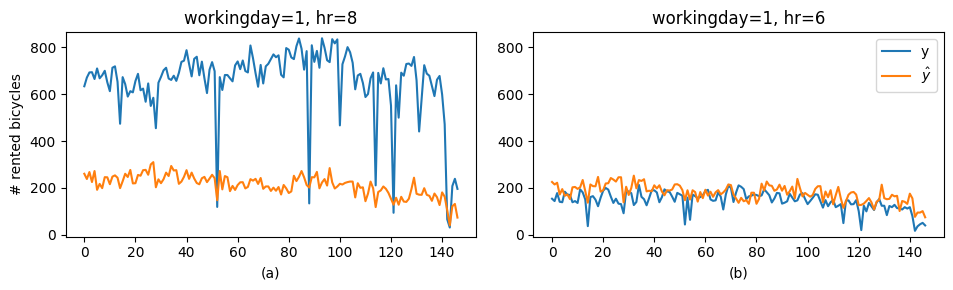

In [37]:
import matplotlib.pyplot as plt

def get_min_max_df(d):
    return d.min().min(), d.max().max()


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9.7, 3)) 

df_tmp_1 = df_discretized_test_all.loc[(df_discretized_test_all["workingday"]==1)&(df_discretized_test_all["hr"]==8)]

ax1.plot(range(0,len(df_tmp_1["cnt"])),df_tmp_1["cnt"], label='y')
ax1.plot(range(0,len(df_tmp_1["cnt_pred"])),df_tmp_1["cnt_pred"], label='$\hat{y}$')
min_v_1, max_v_1 = get_min_max_df(df_tmp_1[["cnt","cnt_pred"]])

df_tmp_2 = df_discretized_test_all.loc[(df_discretized_test_all["workingday"]==1)&(df_discretized_test_all["hr"]==6)]
ax2.plot(range(0,len(df_tmp_2["cnt"])),df_tmp_2["cnt"], label='y')
ax2.plot(range(0,len(df_tmp_2["cnt_pred"])),df_tmp_2["cnt_pred"], label='$\hat{y}$')
min_v_2, max_v_2 = get_min_max_df(df_tmp_2[["cnt", "cnt_pred"]])

ax1.set_ylabel('# rented bicycles')  
min_v, max_v=min(min_v_1, min_v_2), max(max_v_1, max_v_2)
delta=0.03*max_v
ax1.set_ylim(min_v-delta, max_v+delta)
ax2.set_ylim(min_v-delta, max_v+delta)
ax1.set_xlabel('(a)')  
ax2.set_xlabel('(b)')  
# ax.set_ylabel('y label')  # Add a y-label to the axes.
ax1.set_title("workingday=1, hr=8")
ax2.set_title("workingday=1, hr=6")
ax2.legend()
plt.tight_layout()
plt.savefig("y_y_pred_rentings_workingday_h8vsh6.pdf")